In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as animation
mpl.style.use(['fivethirtyeight', 'figsize'])
_SAVEDIR_ = 'Tex/figures/'
from IPython.display import HTML


def prog_bar(cur_val,max_val,msg = ""):
    import sys
    sys.stdout.write('\r')
    eq = int(np.ceil(np.true_divide(cur_val*100,max_val*5)))
    sys.stdout.write("[{:20s}] {}/{} {:}  ".format('='*eq, cur_val+1,max_val,msg))
    sys.stdout.flush()


In [1]:
def init(rho_in,f=None):
    if f is None:
        f = np.zeros([Nsteps, 9,lx,ly])
    
    rho = np.ones([lx,ly])*rho_in
    rho = rho_in*(1+.01*(np.random.rand(lx,ly)-.5)*2)
    
    u = np.zeros([lx,ly])
    v = np.zeros([lx,ly])
    for kk in range(0,9):  
        f[0,kk,:,:] = w[kk]*rho
    return f, rho, u ,v
        
    # Init rho with perturbation
def calc_macro(f,rho,u,v):
    # f should be at a given time step
    u[:,:] = 0
    v[:,:] = 0
    
    rho = np.sum(f,axis=0)
    for k in range(9):
        u += f[k]*ex[k]
        v += f[k]*ey[k]
    u=u/rho
    v=v/rho
    return rho, u ,v
def force(rho, u, v):
    # omega, and rho_psi are global variables
    psi = rho_psi*(1-np.exp(-rho/rho_psi))
    # a negative roll velocity implied i+1

    f_x = psi*(np.roll(psi,(-1,0),(0,1))-np.roll(psi,(1,0),(0,1)))
    f_y = psi*(np.roll(psi,(0,-1),(0,1))-np.roll(psi,(0,1),(0,1)))

    f2_x = psi*(np.roll(psi,(-1,1),(0,1))+np.roll(psi,(-1,-1),(0,1))
                -np.roll(psi,(1,1),(0,1))-np.roll(psi,(1,-1),(0,1)))


    f2_y = psi*(np.roll(psi,(-1,-1),(0,1))+np.roll(psi,(1,-1),(0,1))
                -np.roll(psi,(1,1),(0,1))-np.roll(psi,(-1,1),(0,1)))
#     f_x = np.zeros([lx,ly])
#     f_y = np.zeros([lx,ly])
#     f2_x = np.zeros([lx,ly])
#     f2_y = np.zeros([lx,ly])
#     for i in range(lx):
#         for j in range(ly):
#             f_x[i,j]  =  psi[i,j]*(psi[(i+1)%lx,j]-psi[i-1,j])
#             f_y[i,j]  =  psi[i,j]*(psi[i,(j+1)%ly]-psi[i,j-1])
#             f2_x[i,j] = psi[i,j]*(psi[(i+1)%lx,(j-1)%ly]+psi[(i+1)%lx,(j+1)%ly]
#                                   -psi[(i-1)%lx,(j-1)%ly]-psi[(i-1)%lx,(j+1)%ly])
#             f2_y[i,j] = psi[i,j]*(-psi[(i+1)%lx,(j-1)%ly]+psi[(i+1)%lx,(j+1)%ly]
#                                   -psi[(i-1)%lx,(j-1)%ly]+psi[(i-1)%lx,(j+1)%ly])

    force_x = G*(f_x/9+f2_x/36)
    force_y = G*(f_y/9+f2_y/36)


    # shift equlibrium
    u += force_x/(omega*rho)
    v += force_y/(omega*rho)
    return u, v

def force2(rho):
    # omega, and rho_psi are global variables
    psi = rho_psi*(1-np.exp(-rho/rho_psi))
    # a negative roll velocity implied i+1
    def psi(rho):
        return (1-np.exp(-rho))
    F = np.zeros([9,lx,ly])
#     for k in range(9):
        

    # shift equlibrium
    u += force_x/(omega*rho)
    v += force_y/(omega*rho)
    return u, v

def equilibrium(u, v, rho, f, ts):
    # also implements falcucci's collis method
    # maybe needs to return an object, but I think this should modify the original array
    for k in range(0,9):
        cu = (1./cs**2)*(ex[k]*u+ey[k]*v)
        feq = rho*w[k]*(1.+cu+cu**2-(u**2+v**2)/(2*cs**2))
        f[ts, k, :,:] = f[ts-1,k,:,:] +(1./omega)*(feq-f[ts-1,k,:,:])

def run(f=None):
# initialization
    f, rho, u, v = init(rho_in,f)
#     equilibrium(u, v, rho, f, ts)

    # main loop
    for ts in range(1,Nsteps):
        # prog bar
        prog_bar(ts,Nsteps)
#         equilibrium(u, v, rho, f, ts)
        fout = np.copy(f[ts])
        for kk in range(0,9): 
            f[ts,kk,:,:] = np.roll(fout[kk,:,:],(ex[kk],ey[kk]),(0,1))

        # calc macro quanitites
        rho, u, v = calc_macro(f[ts-1],rho,u,v)

        # force + collision
        u, v = force(rho, u, v)
        
        equilibrium(u, v, rho, f, ts)
        
  
        rho, u, v = calc_macro(f[ts],rho,u,v)
        u = (u+calc_macro_f(f[ts-1])[1])/2
        v = (v+calc_macro_f(f[ts-1])[2])/2
        # prepare the next time step

        # streaming
    return f
def calc_macro_f(f):
    #Assumes f at a given time step
    #  this fxn shouldn't be used in the loops as it takes times to create new numpy arrays
    # useful after running for getting macro quantities w/o having the rho,u, and v arrays handy
    u = np.zeros([lx,ly])
    v = np.zeros([lx,ly])
    
    rho = np.sum(f,axis=0)
    for k in range(9):
        u += f[k]*ex[k]
        v += f[k]*ey[k]
    u=u/rho
    v=v/rho
    return rho, u ,v

In [3]:
def run(f=None):
# initialization
    f, rho, u, v = init(rho_in,f)
#     equilibrium(u, v, rho, f, ts)

    # main loop
    for ts in range(1,Nsteps):
        prog_bar(ts,Nsteps)

        

        # calc macro quanitites
        rho, u, v = calc_macro(f[ts-1],rho,u,v)
        

        # force + collision
        u, v = force(rho, u, v)
        
        equilibrium(u, v, rho, f, ts)
        
        fout = np.copy(f[ts])
        for kk in range(0,9): 
            f[ts,kk,:,:] = np.roll(fout[kk,:,:],(ex[kk],ey[kk]),(0,1))
  
        rho, u, v = calc_macro(f[ts],rho,u,v)
#         u = (u+calc_macro_f(f[ts-1])[1])/2
#         v = (v+calc_macro_f(f[ts-1])[2])/2
        # prepare the next time step

        # streaming
    return f

[====================] 1000/1000   

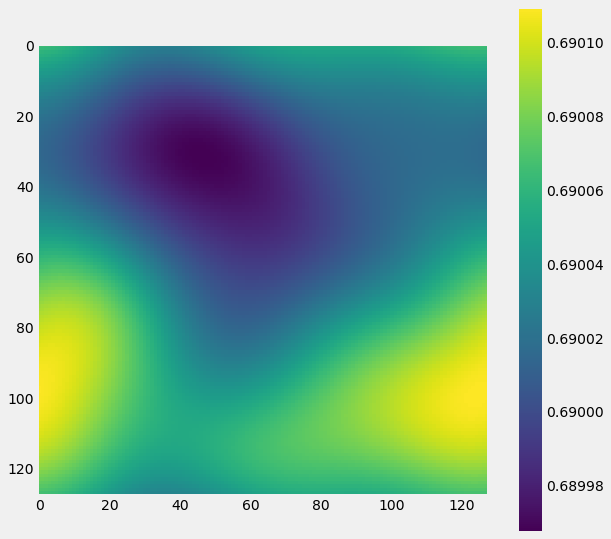

In [4]:
# Define parameters
G = -4.5
visc = 1/6
dt = 1
dx = 1
rho_psi = 1
rho_in = .69
omega = 1/(3.*visc*(dt*dt)/(dx*dx) + 0.5*dt) # this is just one....
lx = 128
ly = lx
Nsteps = 1000
cs=1./np.sqrt(3)


w = [4./9,1./9,1./9,1./9,1./9,1./36,1./36,1./36,1./36] 
ex=[0,1,0,-1,0 ,1,-1,-1, 1]
ey=[0,0,1,0 ,-1,1, 1,-1,-1]
f_out = run()

plt.imshow(calc_macro_f(f_out[-1])[0])
plt.colorbar()
plt.grid('off')
plt.show()

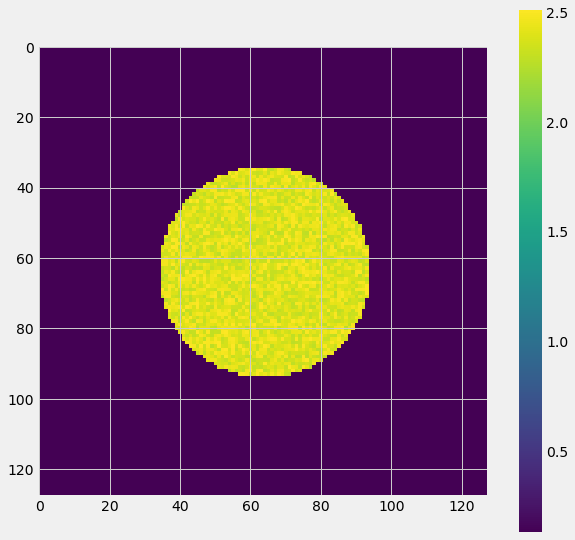

In [43]:
rho = np.zeros([lx,ly])
disp_x = lx/2
disp_y = ly/2
y,x = np.ogrid[-disp_x:lx-disp_x,-disp_y:ly-disp_y]
radius = 30
mask = x*x +y*y < radius**2
rho[mask] = 2.4
rho *= 1+.05*(np.random.rand(lx,ly)-.5)*2
rho[mask == 0] = .125
plt.imshow(rho.T)
plt.colorbar()

In [90]:
def init_circ(rho_in,f=None):
    if f is None:
        f = np.zeros([Nsteps, 9,lx,ly])
    else:
        f[:,:,:]=0
    rho = np.zeros([lx,ly])
    disp_x = lx/2
    disp_y = ly/2
    y,x = np.ogrid[-disp_x:lx-disp_x,-disp_y:ly-disp_y]
    radius = 30
    mask = x*x +y*y < radius**2
    rho[mask] = 2.4
    rho *= 1+.05*(np.random.rand(lx,ly)-.5)*2
    rho[mask == 0] = .125

    
#     rho = np.ones([lx,ly])*rho_in
#     rho = rho_in*(1+.01*(np.random.rand(lx,ly)-.5)*2)
    
    u = np.zeros([lx,ly])
    v = np.zeros([lx,ly])
    for kk in range(0,9):  
        f[0,kk,:,:] = w[kk]*rho
    return f, rho, u ,v
        
    # Init rho with perturbation
def force2(rho, u, v):
    # omega, and rho_psi are global variables
    psi = rho_psi*(1-np.exp(-rho/rho_psi))
    # a negative roll velocity implied i+1

    f_x = psi*(np.roll(psi,(-1,0),(0,1))-np.roll(psi,(1,0),(0,1)))
    f_y = psi*(np.roll(psi,(0,-1),(0,1))-np.roll(psi,(0,1),(0,1)))

    f2_x = psi*(np.roll(psi,(-1,1),(0,1))+np.roll(psi,(-1,-1),(0,1))
                -np.roll(psi,(1,1),(0,1))-np.roll(psi,(1,-1),(0,1)))


    f2_y = psi*(np.roll(psi,(-1,-1),(0,1))+np.roll(psi,(1,-1),(0,1))
                -np.roll(psi,(1,1),(0,1))-np.roll(psi,(-1,1),(0,1)))

    force_x = -G*(f_x/9+f2_x/36)
    force_y = -G*(f_y/9+f2_y/36)


    # shift equlibrium
    u += force_x/(omega*rho)
    v += force_y/(omega*rho)
    return u, v

def run_circ(f=None):
# initialization
    f, rho, u, v = init_circ(rho_in,f)
#     equilibrium(u, v, rho, f, ts)

    # main loop
    for ts in range(1,Nsteps):
        # prog bar
        prog_bar(ts,Nsteps)
#         equilibrium(u, v, rho, f, ts)
        fout = np.copy(f[ts])
        for kk in range(0,9): 
            f[ts,kk,:,:] = np.roll(fout[kk,:,:],(ex[kk],ey[kk]),(0,1))

        # calc macro quanitites
        rho, v, u = calc_macro(f[ts],rho,u,v)

        # force + collision
#         u, v = force2(rho, u, v)
        
        equilibrium(u, v, rho, f, ts)
        
  
        rho, u, v = calc_macro(f[ts],rho,u,v)
#         u = (u+calc_macro_f(f[ts-1])[1])/2
#         v = (v+calc_macro_f(f[ts-1])[2])/2
        # prepare the next time step

        # streaming
    return f
def plot_dens(f):
    lst =[]
    for i in range(f.shape[0]):
        lst.append(np.sum(calc_macro_f(f[i])[0])/(lx*ly))
    plt.plot(list(range(f.shape[0])),lst)
    plt.xlabel('Time Step')
    plt.ylabel('Total Mass')
    plt.show()

[=                   ] 32/1000   

/home/ianhi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/home/ianhi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


[====================] 1000/1000   

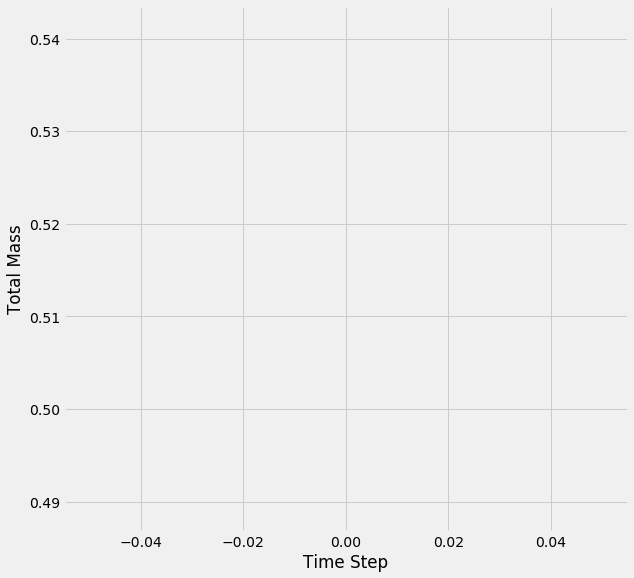

In [91]:
f_out = run_circ(f_out)
plot_dens(f_out)

In [83]:
np.sum(calc_macro_f(f_out[0])[0]/(lx*ly))

0.51454630499099929

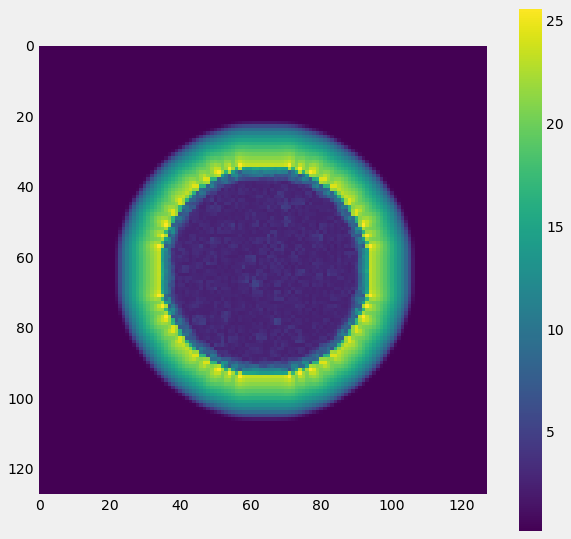

In [55]:
plt.imshow(calc_macro_f(f_out[40])[0])
plt.colorbar()
plt.grid('off')
plt.show()

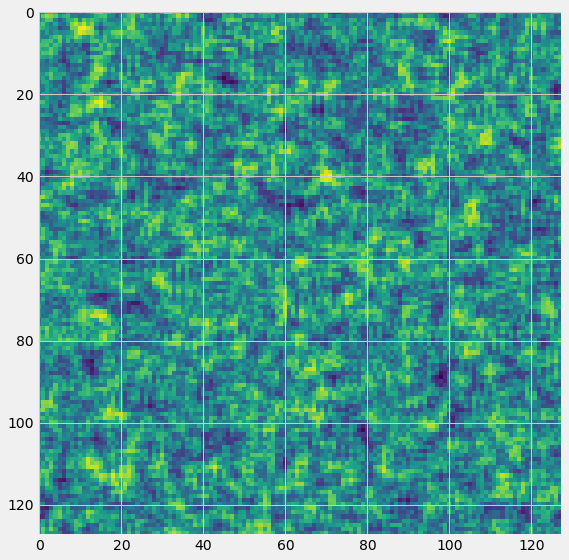

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [14]:
fig,ax = plt.subplots()
def draw(i):
    ax.imshow(calc_macro_f(f_out[i])[0].T)
#     colorbar()
def animate(i):
    ax.clear()
    draw(i)
    return ax,
draw(0)
anim = animation.FuncAnimation(fig, animate, np.arange(1, 900), interval=50)
plt.show()
HTML(anim.to_html5_video())

In [16]:
anim.save("out_mov.mp4")

In [21]:
print(np.sum(calc_macro_f(f_out[0])[0]))
print(np.sum(calc_macro_f(f_out[10])[0]))


11305.2007469
11305.3725039


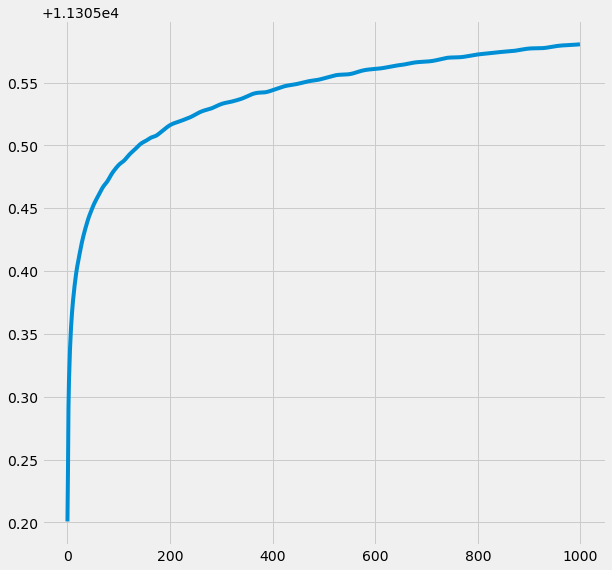

In [19]:
lst = []
for i in range(Nsteps):
    lst.append(np.sum(calc_macro_f(f_out[i])[0]))
plt.plot(list(range(Nsteps)),lst)

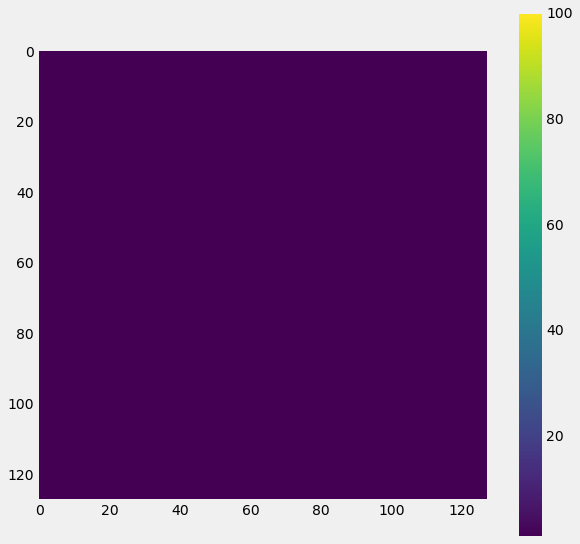

In [7]:

plt.imshow(calc_macro_f(f_out[-1])[0],vmax=100)
plt.colorbar()
plt.grid('off')
plt.show()

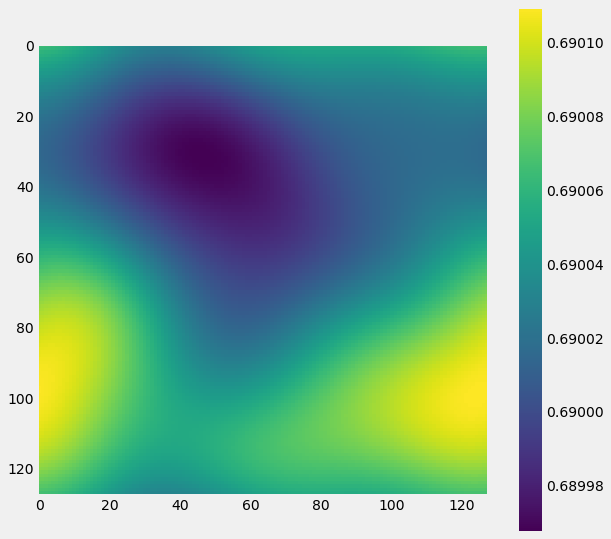

In [8]:


plt.imshow(calc_macro_f(f_out[-1])[0])
plt.colorbar()
plt.grid('off')
plt.show()

In [9]:
print(np.min(calc_macro_f(f_out[-1])[0]))
np.max(calc_macro_f(f_out[-1])[0])

0.689967450321


0.69010967796348521

In [10]:
psi = np.arange(1,5)
print(psi)
print(psi*(np.roll(psi,-1,0)-np.roll(psi,1,0)))
for i in range(4):
    print(psi[i]*(psi[(i+1)%4]-psi[i-1]))

[1 2 3 4]
[-2  4  6 -8]
-2
4
6
-8


In [11]:
psi =np.zeros([5,5])
psi[:,:] = np.arange(1,6)
psi[3,4] = 4
print(psi*(np.roll(psi,(-1,0),(0,1))-np.roll(psi,(1,0),(0,1))))
for i in range(5):
    print(psi[i,:]*(psi[(i+1)%4,:]-psi[i-1,:]))

[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -5.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  5.]]
[ 0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.]
[ 0.  0.  0.  0. -5.]
[ 0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  5.]


In [12]:
# a negative roll velocity implied i+1

f_x = psi*(np.roll(psi,(0,-1),(0,1))-np.roll(psi,(0,1),(0,1)))
f_y = psi*(np.roll(psi,(0,-1),(0,1))-np.roll(psi,(0,1),(0,1)))

f2_x = psi*(np.roll(psi,(-1,1),(0,1))+np.roll(psi,(-1,-1),(0,1))
            -np.roll(psi,(1,1),(0,1))-np.roll(psi,(1,-1),(0,1)))


f2_y = psi*(np.roll(psi,(-1,-1),(0,1))+np.roll(psi,(1,-1),(0,1))
            -np.roll(psi,(1,1),(0,1))-np.roll(psi,(-1,1),(0,1)))

force_x = -G*(f_x*1/9+f2_x*1/36)
force_y = -G*(f_y*1/9+f2_y*1/36)


# shift equlibrium
u += force_x/(omega*rho)
v += force_y/(omega*rho)

NameError: name 'u' is not defined

In [ ]:
f_out[4,4].shape

In [ ]:
a = np.floor(np.random.rand(5,5)*20)
print(a.T)

In [ ]:
kk = 8
print(np.flipud(np.roll(a,(ex[kk],ey[kk]),(0,1)).T))


In [ ]:
print(np.flipud(a.T))
a[0,1]


In [ ]:
b = np.floor(np.random.rand(2,5,5)*20)
print(b)
np.sum(b,axis=0)

In [ ]:
    f_x = psi*(np.roll(psi,(-1,0),(0,1))-np.roll(psi,(1,0),(0,1)))
    f_y = psi*(np.roll(psi,(0,-1),(0,1))-np.roll(psi,(0,1),(0,1)))

    f2_x = psi*(np.roll(psi,(-1,1),(0,1))+np.roll(psi,(-1,-1),(0,1))
                -np.roll(psi,(1,1),(0,1))-np.roll(psi,(1,-1),(0,1)))


    f2_y = psi*(np.roll(psi,(-1,-1),(0,1))+np.roll(psi,(1,-1),(0,1))
                -np.roll(psi,(1,1),(0,1))-np.roll(psi,(-1,1),(0,1)))


In [74]:
psi = np.array([1,2,3,4])
print(psi*(np.roll(psi,(-1),(0))-np.roll(psi,(1),(0))))


[-2  4  6 -8]


In [ ]:
def init(rho_in,f=None):
    if f is None:
        f = np.zeros([Nsteps, 9,lx,ly])
    
    rho = np.ones([lx,ly])*rho_in
    rho = rho_in*(1+.01*(np.random.rand(lx,ly)-.5)*2)
    
    u = np.zeros([lx,ly])
    v = np.zeros([lx,ly])
    for kk in range(0,9):  
        f[0,kk,:,:] = w[kk]*rho
    return f, rho, u ,v
        
    # Init rho with perturbation
def calc_macro(f,rho,u,v):
    # f should be at a given time step
    u[:,:] = 0
    v[:,:] = 0
    
    rho = np.sum(f,axis=0)
    for k in range(9):
        u += f[k]*ex[k]
        v += f[k]*ey[k]
    u=u/rho
    v=v/rho
    return rho, u ,v
def force(rho, u, v):
    # omega, and rho_psi are global variables
    psi = rho_psi*(1-np.exp(-rho/rho_psi))
    # a negative roll velocity implied i+1

    f_x = psi*(np.roll(psi,(-1,0),(0,1))-np.roll(psi,(1,0),(0,1)))
    f_y = psi*(np.roll(psi,(0,-1),(0,1))-np.roll(psi,(0,1),(0,1)))

    f2_x = psi*(np.roll(psi,(-1,1),(0,1))+np.roll(psi,(-1,-1),(0,1))
                -np.roll(psi,(1,1),(0,1))-np.roll(psi,(1,-1),(0,1)))


    f2_y = psi*(np.roll(psi,(-1,-1),(0,1))+np.roll(psi,(1,-1),(0,1))
                -np.roll(psi,(1,1),(0,1))-np.roll(psi,(-1,1),(0,1)))
#     f_x = np.zeros([lx,ly])
#     f_y = np.zeros([lx,ly])
#     f2_x = np.zeros([lx,ly])
#     f2_y = np.zeros([lx,ly])
#     for i in range(lx):
#         for j in range(ly):
#             f_x[i,j]  =  psi[i,j]*(psi[(i+1)%lx,j]-psi[i-1,j])
#             f_y[i,j]  =  psi[i,j]*(psi[i,(j+1)%ly]-psi[i,j-1])
#             f2_x[i,j] = psi[i,j]*(psi[(i+1)%lx,(j-1)%ly]+psi[(i+1)%lx,(j+1)%ly]
#                                   -psi[(i-1)%lx,(j-1)%ly]-psi[(i-1)%lx,(j+1)%ly])
#             f2_y[i,j] = psi[i,j]*(-psi[(i+1)%lx,(j-1)%ly]+psi[(i+1)%lx,(j+1)%ly]
#                                   -psi[(i-1)%lx,(j-1)%ly]+psi[(i-1)%lx,(j+1)%ly])

    force_x = G*(f_x/9+f2_x/36)
    force_y = G*(f_y/9+f2_y/36)


    # shift equlibrium
    u += force_x/(omega*rho)
    v += force_y/(omega*rho)
    return u, v

def force2(rho):
    # omega, and rho_psi are global variables
    psi = rho_psi*(1-np.exp(-rho/rho_psi))
    # a negative roll velocity implied i+1
    def psi(rho):
        return (1-np.exp(-rho))
    F = np.zeros([9,lx,ly])
#     for k in range(9):
        

    # shift equlibrium
    u += force_x/(omega*rho)
    v += force_y/(omega*rho)
    return u, v

def equilibrium(u, v, rho, f, ts):
    # also implements falcucci's collis method
    # maybe needs to return an object, but I think this should modify the original array
    for k in range(0,9):
        cu = (1./cs**2)*(ex[k]*u+ey[k]*v)
        feq = rho*w[k]*(1.+cu+cu**2-(u**2+v**2)/(2*cs**2))
        f[ts, k, :,:] = f[ts-1,k,:,:] +(1./omega)*(feq-f[ts-1,k,:,:])

def run(f=None):
# initialization
    f, rho, u, v = init(rho_in,f)
#     equilibrium(u, v, rho, f, ts)

    # main loop
    for ts in range(1,Nsteps):
        # prog bar
        prog_bar(ts,Nsteps)
#         equilibrium(u, v, rho, f, ts)
        fout = np.copy(f[ts])
        for kk in range(0,9): 
            f[ts,kk,:,:] = np.roll(fout[kk,:,:],(ex[kk],ey[kk]),(0,1))

        # calc macro quanitites
        rho, u, v = calc_macro(f[ts-1],rho,u,v)

        # force + collision
        u, v = force(rho, u, v)
        
        equilibrium(u, v, rho, f, ts)
        
  
        rho, u, v = calc_macro(f[ts],rho,u,v)
        u = (u+calc_macro_f(f[ts-1])[1])/2
        v = (v+calc_macro_f(f[ts-1])[2])/2
        # prepare the next time step

        # streaming
    return f
def calc_macro_f(f):
    #Assumes f at a given time step
    #  this fxn shouldn't be used in the loops as it takes times to create new numpy arrays
    # useful after running for getting macro quantities w/o having the rho,u, and v arrays handy
    u = np.zeros([lx,ly])
    v = np.zeros([lx,ly])
    
    rho = np.sum(f,axis=0)
    for k in range(9):
        u += f[k]*ex[k]
        v += f[k]*ey[k]
    u=u/rho
    v=v/rho
    return rho, u ,v

## Doing circular without methods

[==                  ] 2/10   69.375
[====                ] 3/10   138.75
[======              ] 4/10   277.5
[========            ] 5/10   555.0
[==========          ] 6/10   1110.0
[============        ] 7/10   2220.0
[==============      ] 8/10   4440.0
[================    ] 9/10   8880.0
[==================  ] 10/10   17760.0


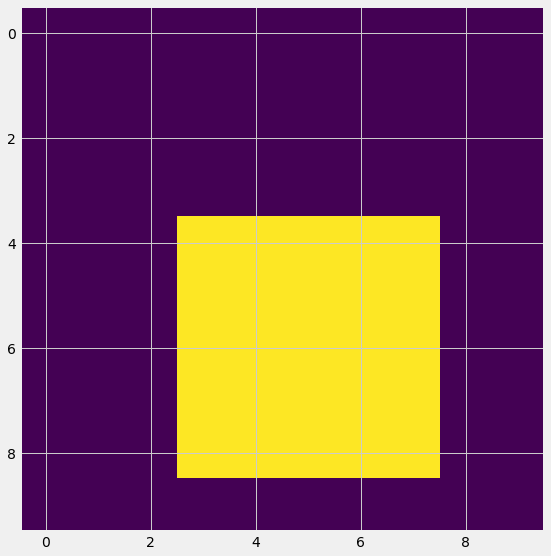

In [327]:
def init_circ(rho_in,f=None):
    if f is None:
        f = np.zeros([Nsteps, 9,lx,ly])
    else:
        f[:,:,:]=0
    rho = np.zeros([lx,ly])
    disp_x = lx/2
    disp_y = ly/2
    y,x = np.ogrid[-disp_x:lx-disp_x,-disp_y:ly-disp_y]
    radius = 30
    mask = x*x +y*y < radius**2
    rho[mask] = 2.4
    rho *= 1+.05*(np.random.rand(lx,ly)-.5)*2
    rho[mask == 0] = .125

    
#     rho = np.ones([lx,ly])*rho_in
#     rho = rho_in*(1+.01*(np.random.rand(lx,ly)-.5)*2)
    
    u = np.zeros([lx,ly])
    v = np.zeros([lx,ly])
    for kk in range(0,9):  
        f[0,kk,:,:] = w[kk]*rho
    return f, rho, u ,v
        
    # Init rho with perturbation
def flip_T(a):
    return np.flipud(a.T)
lx =10
ly = lx
Nsteps = 10
ex=[0,1,0,-1,0 ,1,-1,-1, 1]
ey=[0,0,1,0 ,-1,1, 1,-1,-1]
# initialization
f = np.zeros([Nsteps, 9,lx,ly])
u = np.zeros([lx,ly])
v = np.zeros([lx,ly])

rho = np.zeros([lx,ly])
disp_x = lx/2+1
disp_y = ly/2
y,x = np.ogrid[-disp_x:lx-disp_x,-disp_y:ly-disp_y]
radius = 3
mask = x*x +y*y < radius**2
rho[mask] = 2.4
# rho *= 1+.05*(np.random.rand(lx,ly)-.5)*2
rho[mask == 0] = .125
for kk in range(0,9):  
    f[0,kk,:,:] = w[kk]*rho
plt.imshow(rho)

for ts in range(1,Nsteps):
    prog_bar(ts,Nsteps)
    
    fout = np.copy(f[ts-1])
    for kk in range(0,9): 
        f[ts,kk,:,:] = np.roll(fout[kk,:,:],(ex[kk],ey[kk]),(0,1))
    
    
    # hydrovar
    rho = np.sum(f[ts],axis=0)
    for j in range(ly):
        for i in range(lx):
            u[i,j] = ( f[ts,1,i,j] - f[ts,3,i,j] + f[ts,5,i,j] -f[ts,6,i,j] - f[ts,7,i,j] + f[ts,8,i,j] ) / rho[i,j]

            v[i,j] = ( f[ts,5,i,j] + f[ts,2,i,j] + f[ts,6,i,j] - f[ts,7,i,j] - f[ts,4,i,j] - f[ts,8,i,j] ) / rho[i,j]


    #===============================
#     print(u)
    # calc macro quanitites
#     rho = np.sum(f[ts],axis=0)
#     for k in range(9):
#         u += f[ts,k]*ex[k]
#         v += f[ts,k]*ey[k]

#     u=u/rho
#     v=v/rho
    #===========================
    print(np.sum(rho))
#     print(u)
    
   
    psi = np.zeros([lx,ly])
    for i in range(lx):
        for j in range(ly):
            psi[i,j] = 1-np.exp(-rho[i,j])
#             print(psi[i,j])
            
    for i in range(lx):
        for j in range(ly):
            fnnx  = psi[i,j]*(psi[(i+1)%lx,j]-psi[i-1,j])
            fnny  = psi[i,j]*(psi[i,(j+1)%ly]-psi[i,j-1])
            fnnnx = psi[i,j]*((psi[(i+1)%lx,j-1]+psi[(i+1)%lx,(j+1)%ly])
                              -psi[i-1,j-1] - psi[i-1,(j+1)%ly])
            fnnny = psi[i,j]*((psi[(i+1)%lx,(j+1)%ly] + psi[i-1,(j+1)%ly]
                               - psi[i-1,j-1] - psi[(i+1)%lx,j-1]))
#             print((-G*fnnx/9 -G*fnnnx/36)/rho[i,j])
            u[i,j] = u[i,j] +(-G*fnnx/9 +G*fnnnx/36)/rho[i,j]
            v[i,j] = v[i,j] +(-G*fnny/9-G*fnnny/36)/rho[i,j]


    # shift equlibrium
#     u += force_x/(omega*rho)
#     v += force_y/(omega*rho)
#     print(u)
    
    #=======================================
    cs2  = 1.00 / 3.00
    cs22 = 2.00 * cs2
    cssq = 2.0 / 9.00
    feq = np.zeros([9,lx,ly])

    for j in range(ly):
        for i in range(lx):
            usq = u[i,j] * u[i,j] 
            vsq = v[i,j] * v[i,j]
            sumsq = (usq + vsq) / cs22 
            sumsq2 = sumsq * (1.00 - cs2) / cs2
            u22 = usq / cssq 
            v22 = vsq / cssq 
            ui = u[i,j] / cs2
            vi = v[i,j] / cs2
            uv = ui * vi 
            rhoij = rho[i,j]



            feq[0,i,j] = (4.0/9.0)*rhoij*(1.00 - sumsq)

            feq[1,i,j] = (1.0/9.0)*rhoij*(1.00 - sumsq + u22 + ui)
            feq[2,i,j] = (1.0/9.0)*rhoij*(1.00 - sumsq + v22 + vi)
            feq[3,i,j] = (1.0/9.0)*rhoij*(1.00 - sumsq + u22 - ui)
            feq[4,i,j] = (1.0/9.0)*rhoij*(1.00 - sumsq + v22 - vi)

            feq[5,i,j] = (1.0/36.0)*rhoij*(1.00 + sumsq2 + ui + vi + uv)
            feq[6,i,j] = (1.0/36.0)*rhoij*(1.00 + sumsq2 - ui + vi - uv)
            feq[7,i,j] = (1.0/36.0)*rhoij*(1.00 + sumsq2 - ui - vi + uv)
            feq[8,i,j] = (1.0/36.0)*rhoij*(1.00 + sumsq2 + ui - vi - uv)

    for k in range(9):
        for i in range(lx):
            for j in range(ly):
                f[ts,k,i,j] += feq[k,i,j]
    
    # hydrovar
    rho = np.sum(f[ts],axis=0)
    for j in range(ly):
        for i in range(lx):
            u[i,j] = ( f[ts,1,i,j] - f[ts,3,i,j] + f[ts,5,i,j] -f[ts,6,i,j] - f[ts,7,i,j] + f[ts,8,i,j] ) / rho[i,j]

            v[i,j] = ( f[ts,5,i,j] + f[ts,2,i,j] + f[ts,6,i,j] - f[ts,7,i,j] - f[ts,4,i,j] - f[ts,8,i,j] ) / rho[i,j]


#     equilibrium(u, v, rho, f, ts)




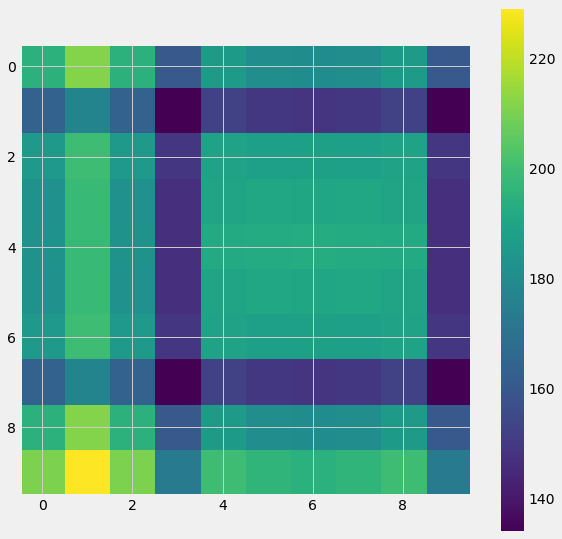

In [326]:
# plt.imshow(calc_macro_f(f[0])[1])
# plt.colorbar()
# plt.show()
plt.imshow(flip_T(calc_macro_f(f[8])[0]))
plt.colorbar()
plt.show()

In [287]:
print([flip_T(calc_macro_f(f[2])[0])>10])

[array([[False, False, False,  True,  True,  True,  True,  True, False,
        False],
       [False, False, False, False, False, False,  True, False, False,
        False],
       [False,  True,  True,  True,  True,  True,  True,  True, False,
         True],
       [False,  True, False,  True, False, False, False,  True, False,
         True],
       [False,  True,  True,  True, False, False, False,  True,  True,
         True],
       [False,  True, False,  True, False, False, False,  True,  True,
         True],
       [False,  True, False,  True,  True,  True,  True,  True,  True,
         True],
       [False, False, False,  True,  True, False,  True,  True, False,
        False],
       [False, False, False,  True,  True,  True,  True,  True, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False]], dtype=bool)]


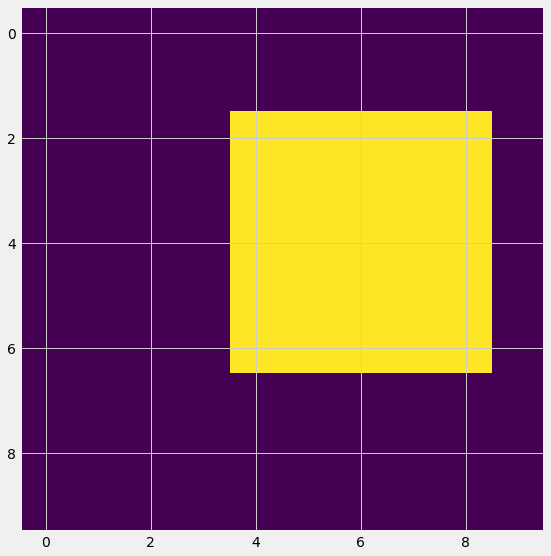

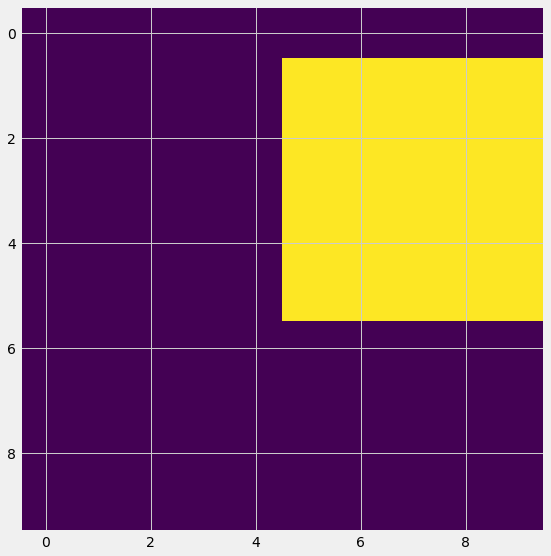

In [306]:
tst = 5
plt.imshow(flip_T(f[0,tst]))
plt.show()
fout = np.copy(f[0])
fnew = np.zeros_like(f[0])
for kk in range(0,9): 
    fnew[kk,:,:] = np.roll(fout[kk,:,:],(ex[kk],ey[kk]),(0,1))
# fnew[1,:,:] = np.roll(fout[1,:,:],(ex[1],ey[1]),(0,1))
plt.imshow(flip_T(fnew[tst]))

In [259]:
fnew

array([[[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.       

In [316]:
rho = np.sum(f_out[1],axis=0)
u = np.zeros([lx,ly])
v = np.zeros([lx,ly])
for k in range(9):
    u[]
# f = 
psi = np.zeros([lx,ly])
force_y = np.zeros([lx,ly])
for i in range(lx):
    for j in range(ly):
        psi[i,j] = 1-np.exp(-rho[i,j])
#             print(psi[i,j])

for i in range(lx):
    for j in range(ly):
        fnnx  = psi[i,j]*(psi[(i+1)%lx,j]-psi[i-1,j])
        fnny  = psi[i,j]*(psi[i,(j+1)%ly]-psi[i,j-1])
        fnnnx = psi[i,j]*((psi[(i+1)%lx,j-1]+psi[(i+1)%lx,(j+1)%ly])
                          -psi[i-1,j-1] - psi[i-1,(j+1)%ly])
        fnnny = psi[i,j]*((psi[(i+1)%lx,(j+1)%ly] + psi[i-1,(j+1)%ly]
                           - psi[i-1,j-1] - psi[(i+1)%lx,j-1]))
        print((-G*fnnx/9 -G*fnnnx/36)/rho[i,j])
        u[i,j] = u[i,j] +(-G*fnnx/9 +G*fnnnx/36)/rho[i,j]
        v[i,j] = v[i,j] +(-G*fnny/9-G*fnnny/36)/rho[i,j]


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
